In [1]:
!pip install IPython

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
import scipy

C:\Users\Sakib\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
labels =[]
paths = []
for dirname, _, filenames in os.walk('SUBESCO/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-2] + filename.split('_')[-1]
        label = filename.split('_')[-2]
        labels.append(label.lower())
print('dataset loading complete')

dataset loading complete


In [4]:
#creating a data frame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,SUBESCO/F_01_OISHI_S_10_ANGRY_1.wav,angry
1,SUBESCO/F_01_OISHI_S_10_ANGRY_2.wav,angry
2,SUBESCO/F_01_OISHI_S_10_ANGRY_3.wav,angry
3,SUBESCO/F_01_OISHI_S_10_ANGRY_4.wav,angry
4,SUBESCO/F_01_OISHI_S_10_ANGRY_5.wav,angry


In [5]:
#feature extraction using MFCC-
def feature_extraction(filename, mfcc, chroma, mel):
    d, srate = librosa.load(filename, duration=3, offset=0.5)
    d=scipy.signal.wiener(d)
    if chroma:
        stft = np.abs(librosa.stft(d))
        stft= librosa.amplitude_to_db(stft)
    result = np.array([])
    if mfcc:
        mfccr = np.abs(np.mean(librosa.feature.mfcc(d, sr=srate, n_mfcc=23).T, axis=0))
        result = np.hstack((result, mfccr))
    if chroma:
        chroma = np.abs(np.mean(librosa.feature.chroma_stft(S=stft, sr=srate).T, axis=0))
        result = np.hstack((result, chroma))
    if mel:
        mel= np.mean(librosa.feature.melspectrogram(d, sr=srate, n_mels=40).T, axis=0)
        mel = np.abs(librosa.power_to_db(mel))
        result = np.hstack((result, mel))
    return result

In [6]:
p=[feature_extraction(df['speech'][0], mfcc=True, chroma=True, mel=True)]
np.array(p)

array([[1.57808637e+02, 7.20476797e+01, 1.12137017e+01, 1.71529251e+01,
        4.02481386e-01, 2.02619339e+00, 2.90358293e+00, 5.91999467e+00,
        5.09802873e+00, 8.65040254e-01, 2.74390924e+00, 4.17027529e+00,
        1.36155973e+00, 6.69072583e-01, 3.10519883e+00, 3.49791117e+00,
        2.26512739e+00, 2.31283607e+00, 2.82023226e+00, 9.91639352e-01,
        1.20523873e+00, 1.23389252e+00, 5.27648686e+00, 7.49478991e-02,
        1.31466609e-01, 1.85755776e-01, 1.80768686e-01, 1.73390973e-01,
        9.11324158e-02, 1.49379427e-02, 2.61438862e-02, 2.32865749e-04,
        2.10804511e-02, 4.72276354e-02, 5.01801436e-02, 6.53717953e+00,
        1.41970466e+01, 2.21735475e+01, 2.11231019e+01, 1.80776107e+01,
        1.95261605e+01, 2.06912832e+01, 1.95371887e+01, 1.42655738e+01,
        1.53605605e+01, 1.60859566e+01, 1.11288477e+01, 8.92768297e+00,
        1.26582730e+01, 1.04214744e+01, 8.12316226e+00, 1.26003335e+01,
        1.16143275e+01, 8.40248529e+00, 7.63023873e+00, 5.660839

In [7]:
X_features= df['speech'].apply(lambda x: feature_extraction(x, mfcc=True, chroma=True, mel=True))

In [8]:
#X-mfcc is in dataframe structure.. convert it into 2D array
X=[x for x in X_features]
np.array(X).shape

(7000, 75)

# SVM Classifier

In [9]:
df_shuffle=df.sample(frac=1)
y_svm = df['label'].to_numpy()
print(y_svm)

['angry' 'angry' 'angry' ... 'surprise' 'surprise' 'surprise']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

#splitting dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y_svm, test_size=0.15)
#Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()), ('SVM', SVC())]
# Create the pipeline steps: steps
pipeline = Pipeline(steps)
#Fit the pipeline to the training set: svc_scaled
svc_scaled= pipeline.fit(X_train, y_train)
#Instantiate and fit a classifier to the unscaled data
svc_unscaled = SVC(kernel = 'linear').fit(X_train, y_train)
#Compute and print metrices
print('Accuracy with scaling:{}'.format(svc_scaled.score(X_test, y_test)))
print('Accuracy without scaling:{}'.format(svc_unscaled.score(X_test, y_test)))

In [12]:
train_acc = float(svc_scaled.score(X_train, y_train)*100)
print("----train accuracy score  %s----" % train_acc )
test_acc = float(svc_scaled.score(X_test, y_test)*100)
print("----test accuracy score  %s----" % test_acc )

----train accuracy score  86.16806722689076----
----test accuracy score  81.33333333333333----


In [13]:
scaled_predictions = svc_scaled.predict(X_test)

In [14]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, classification_report

accuracy= accuracy_score(y_test, scaled_predictions)
print("Accuracy Score: {:.2f}%".format(accuracy*100))
print(confusion_matrix(y_test, scaled_predictions))
print(classification_report(y_test, scaled_predictions))

Accuracy Score: 81.33%
[[143  11   0   4   0   0   1]
 [ 15  93   6   9   2   3  11]
 [  1   4 134   4  10   4   7]
 [  0  12   0 105   6   4  11]
 [  0   2   0   1 136   6   0]
 [  0   2   5   3  16 128   7]
 [  7   9   6   5   2   0 115]]
              precision    recall  f1-score   support

       angry       0.86      0.90      0.88       159
     disgust       0.70      0.67      0.68       139
        fear       0.89      0.82      0.85       164
       happy       0.80      0.76      0.78       138
     neutral       0.79      0.94      0.86       145
         sad       0.88      0.80      0.84       161
    surprise       0.76      0.80      0.78       144

    accuracy                           0.81      1050
   macro avg       0.81      0.81      0.81      1050
weighted avg       0.82      0.81      0.81      1050



(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

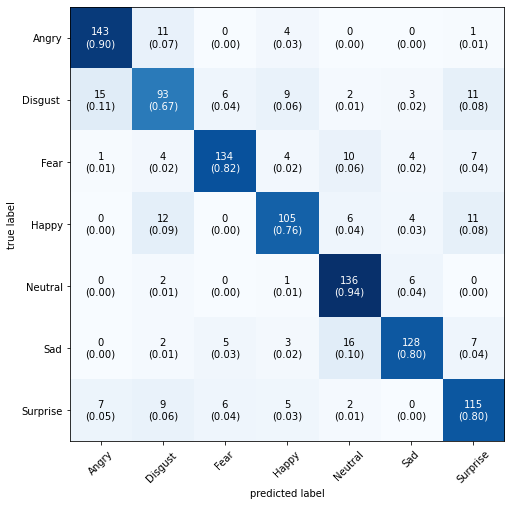

In [15]:
class_names=['Angry', 'Disgust ', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
mat = confusion_matrix(y_test, scaled_predictions)
plot_confusion_matrix(conf_mat=mat, figsize=(8,8), class_names=class_names, show_normed=True)

              precision    recall  f1-score   support

       angry       0.86      0.90      0.88       159
     disgust       0.70      0.67      0.68       139
        fear       0.89      0.82      0.85       164
       happy       0.80      0.76      0.78       138
     neutral       0.79      0.94      0.86       145
         sad       0.88      0.80      0.84       161
    surprise       0.76      0.80      0.78       144

    accuracy                           0.81      1050
   macro avg       0.81      0.81      0.81      1050
weighted avg       0.82      0.81      0.81      1050

----accuracy score  81.33333333333333----


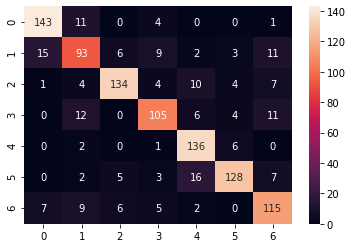

In [16]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, classification_report
import seaborn as sn

print(classification_report(y_test, scaled_predictions))
acc = float(accuracy_score(y_test, scaled_predictions))*100
print("----accuracy score  %s----" % acc)

cm = confusion_matrix(y_test, scaled_predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()